## 0.0 Entender o problema

-- Objetivo do problema:
    -- 1.0 Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Porque?
      --Qual tipo de modelo de negócio do Airbnb?
        --Marketplace (Conectar pessoas que oferecem acomodação, com as pessoas que estão procurando acomodação).
        
        --Oferta (pessoas oferecendo acomodação)
            --Tamanho do Portfólio.
            -- diversidade/Densidade de Portfólio.
            --Preço médio
        
        --Demanda (pessoa procurando acomodação)
             --Número de Usuários 
             --LTV (LifeTime Value)
             --CAC (Client Aquisition Cost)
        
        Gross Revenue = (Fee * Numero de clientes) - CAC
        
        --Demanda (pessoas procurando acomodação)
        
        
--Proposta da solução:

    --- Modelo de previsão do primeiro destino de um novo usuário.
    
    --- 1.0 Predições e salvar em uma tabela de bando de dados.
    
    ---2.0 Criar uma API
        --- Input: usuario  e suas caracteristicas
        --- Output: usuario e suas caracteristicas com a ** predição do destino**.

        
        

# 0.0 <font color ='red'>Ciclo01: End to End </font>

# 0.0 Imports

In [1]:
!pip install scikit-plot

In [64]:
import math
from scipy.stats import chi2_contingency
import scipy.stats as ss
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

import warnings

warnings.filterwarnings( 'ignore' )

import sklearn.model_selection
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt
from IPython.core.display  import HTML
from IPython.core.display  import Image
from tabulate              import tabulate

from imblearn import under_sampling as us
from imblearn import over_sampling  as oversamp
from imblearn import combine        as c

from category_encoders import TargetEncoder
from pandas_profiling import ProfileReport

from keras import models as ml
from keras import layers as l


# 0.1 Helper functions

In [3]:
def cramer_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher. 
        """     
    
    cm = pd.crosstab(x, y).values  #.as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcoor = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n)/ (min(kcorr-1,  rcoor-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

    
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading Data

In [4]:
# datasets source: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data?select=sessions.csv.zip


df_raw = pd.read_csv('dataset/training_users_2.csv', low_memory=True)
df_raw.shape

df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [6]:
print( 'Number of rows: {}'.format(df1.shape[0] ) )
print( 'Number of columns: {}'.format(df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


In [7]:
print( 'Number of rows: {}'.format(df_sessions.shape[0] ) )
print( 'Number of columns: {}'.format(df_sessions.shape[1] ) )

Number of rows: 10567737
Number of columns: 6


## 1.2 Data type

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 NA Check

In [10]:
 df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [12]:
#remove missing value complety
#df1 = df1.dropna()

#========================USER===========================================

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )


# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age =  round(df1['age'].mean(),2)
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

df1['first_affiliate_tracked'].value_counts()

#========================Sessions=========================================
#user_id  - 3%
df_sessions= df_sessions[~df_sessions['user_id'].isna()]

#action - 7%
df_sessions= df_sessions[~df_sessions['action'].isna()]

#action_type - 10$
df_sessions= df_sessions[~df_sessions['action_type'].isna()]

#action_detail- 10%
df_sessions= df_sessions[~df_sessions['action_detail'].isna()]

#device_type - 0%
df_sessions= df_sessions[~df_sessions['device_type'].isna()]

#secs_elapsed - 0%
df_sessions= df_sessions[~df_sessions['secs_elapsed'].isna()]



In [13]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

In [14]:
df1.isna().sum() / len(df1)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

## 1.4 Change Data Type

In [15]:
# date_account_created    
df1["date_account_created"] = pd.to_datetime( df1["date_account_created"] )

# timestamp_first_active   
df1["timestamp_first_active"] = pd.to_datetime( df1["timestamp_first_active"], format='%Y%m%d%H%M%S' )

# date_first_booking       
df1["date_first_booking"] = pd.to_datetime( df1["date_first_booking"] )

# age       
df1["age"] = df1["age"].astype( int )

In [16]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.5 Check Balanced Data

In [17]:
df1["country_destination"].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive Analysis

## 1.6 General

In [18]:
# Users
num_attributes = df1.select_dtypes( include=['int32','int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int32', 'int64', 'float64','datetime64[ns]'])
time_attributes = df1.select_dtypes( include=['datetime64[ns]'])

#Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int32','int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'])

## 1.6.1 Numeral - Users

In [19]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenar 
ct = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes','min','max', 'range','mean','median','std','skew','kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


## 1.6.2 Numeral - Sessions

In [20]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

# concatenar 
ct = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes','min','max', 'range','mean','median','std','skew','kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


## 1.6.2 Categorical - Users

In [21]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


## 1.6.3 Categorical - Sessions

In [22]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


## 1.6.2 Categorical - Sessions

In [23]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

coor_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list =  []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat=cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        # append a list
        corr_list.append(corr)
    # append a correlation list for each atributes   
    coor_dict[ref] = corr_list

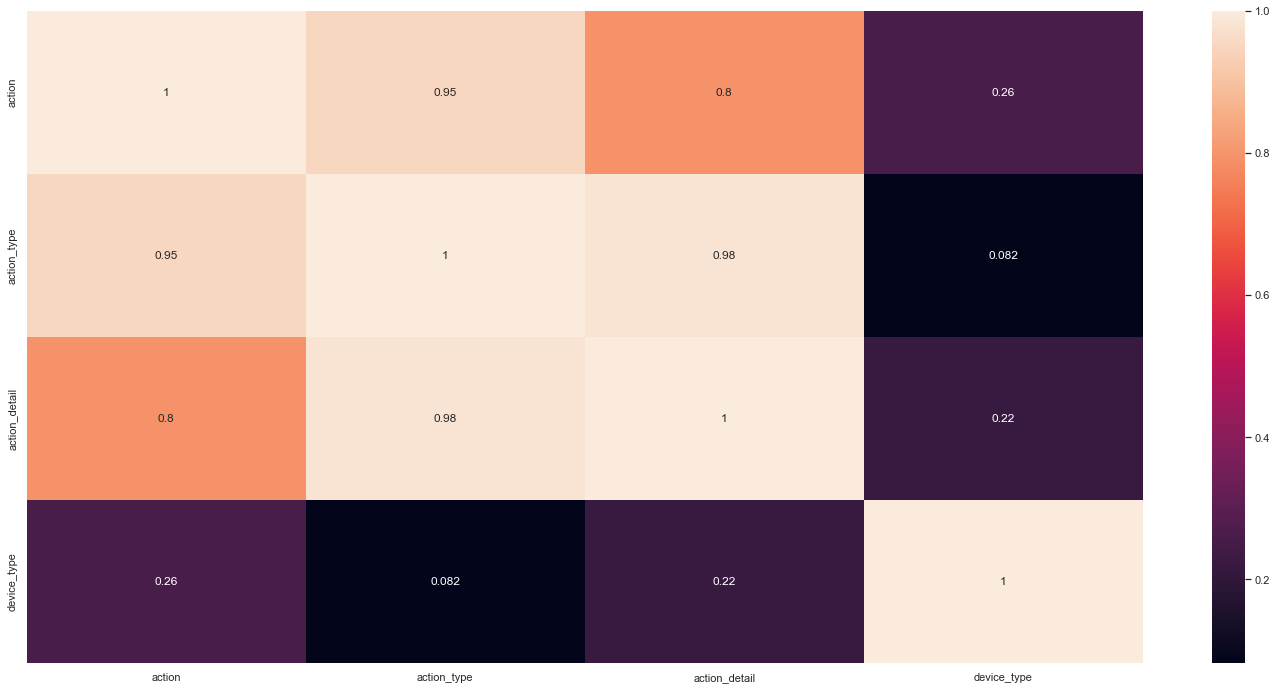

In [24]:
d = pd.DataFrame(coor_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 2.0 Feature Engineering

In [25]:
df2 = df1.copy()
df_sessions2 = df_sessions.copy()

In [26]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Create New Features

In [27]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_first_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# 3.0 Data filtering

In [28]:
df3 = df2.copy()
df_sessions3 = df_sessions2.copy()

## 3.1 Filtering Rows

In [29]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed'] > 0]
df3.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'first_active',
       'days_from_first_active_until_booking',
       'days_from_first_active_until_account_created',
       'days_from_account_created_until_first_booking', 'year_first_active',
       'month_first_active', 'day_first_active', 'day_of_week_first_active',
       'week_of_year_first_active', 'year_first_booking',
       'month_first_booking', 'day_first_booking', 'day_of_week_first_booking',
       'week_of_year_first_booking', 'year_account_created',
       'month_account_created', 'day_account_created',
       'day_of_week_account_created', 'week_of_year_account_created'],
      dtype='object')

## 3.2 Columns Selection

In [30]:
# delete original datetime and high correlation
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 
        'first_active'] # original datetime

df3 = df3.drop( cols, axis=1 )

# 4.0 Balanced Dataset

In [31]:
df4 = df3.copy()

In [32]:
 # Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['id', 'country_destination'], axis=1 ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df42 = pd.concat( [df4[col_num], df4_dummy], axis=1 )
df42.shape

(122636, 236)

##  4.1 Random Undersampling

In [33]:
# ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler( sampling_strategy=ratio_balanced, random_state=32 )

# apply sampler
X_under, y_under = undersampling.fit_resample( df42, df4['country_destination'] )

In [34]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [35]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

 ## 4.2 Random Oversampling

In [36]:
# ratio_balanced
#ratio_balanced = {'NDF': 10000 }

# define sampler
oversampling = oversamp.RandomOverSampler( sampling_strategy='all', random_state=32 )

# apply sampler
X_over, y_over = oversampling.fit_resample( df42, df4['country_destination'] )

In [37]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

In [38]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

 ## 4.3 SMOTE + TOMELINK

In [39]:
#df4['country_destination'].value_counts().to_dict()

ratio_balanced ={'NDF': 54852,
                 'US': 48057,
                 'other': 6*7511,
                 'FR': 12*3669,
                 'IT': 20*2014,
                 'GB': 30*1758,
                 'ES': 30*1685,
                 'CA': 40*1064,
                 'DE': 45*841,
                 'NL': 80*595,
                 'AU': 85*433,
                 'PT': 300*157}



In [40]:
# define sampler
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( df42, df4['country_destination'] )


In [41]:
# numerical data
df43 = X_smt[col_num]

# categorical data
df44 = X_smt.drop(col_num, axis=1)
df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

# join numerical categorical 
df46 = pd.concat([df43,df45], axis=1)
df46['country_destination'] =  y_smt

# 5.0 Exploratory Data Analysis

In [42]:
df51 = df46.copy()
df51.head()

,signup_flow,days_from_first_active_until_booking,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender,age,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,0,2228,732,1496,2009,5,23,5,21,2015,6,29,0,27,2011,5,25,2,21,MALE,38,facebook,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
1,3,419,476,-57,2009,6,9,1,24,2010,8,2,0,31,2010,9,28,1,39,FEMALE,56,basic,en,direct,direct,untracked,Web,Windows Desktop,IE,US
2,0,1043,765,278,2009,10,31,5,44,2012,9,8,5,36,2011,12,5,0,49,FEMALE,42,facebook,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
3,0,72,280,-208,2009,12,8,1,50,2010,2,18,3,7,2010,9,14,1,37,-unknown-,41,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
4,0,3,0,3,2010,1,2,5,53,2010,1,5,1,1,2010,1,2,5,53,FEMALE,46,basic,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


In [43]:
df52 = df4.copy()

## 5.1 Bivariate Analysis - Feature Behavior (Unbalanced Dataset)

 **H01.** Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativacao.

**Verdadeiro.** Em todos os destinos, os usuários até 6 dias para reservar o primeiro Airbnb

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

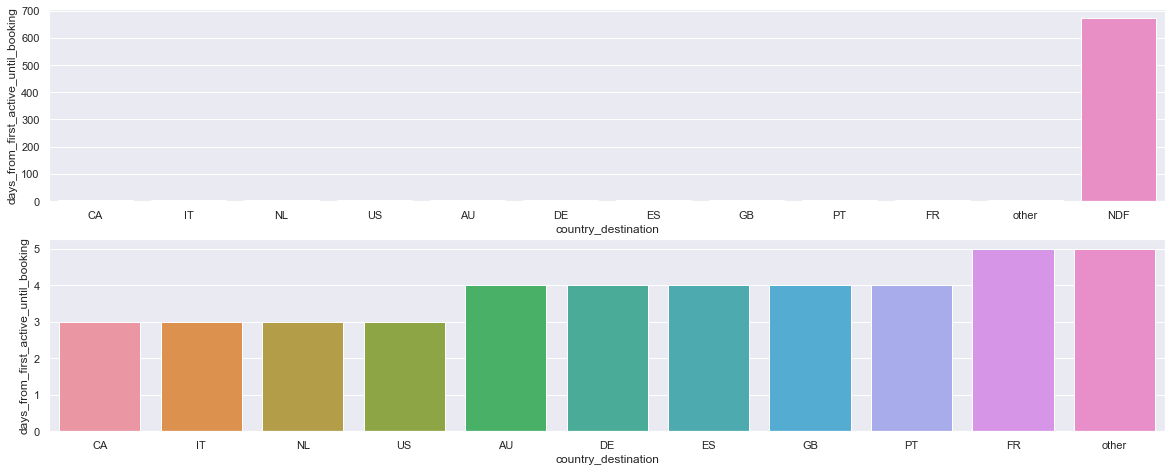

In [44]:
 plt.figure( figsize=(20, 12))
plt.subplot( 3, 1, 1 )
aux01 = df51[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values( 'days_from_first_active_until_booking' ) )

# remove outlier
plt.subplot( 3, 1, 2 )
aux02 = df51[df51['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values( 'days_from_first_active_until_booking' ) )

**H02.** Em todos os destinos, os usuários levam 3 dias, em média, para fazer o cadastro no site.

**Verdadeira.** Em todos os destinos, os usuários levam até 2 dias para finalizar o cadastro

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

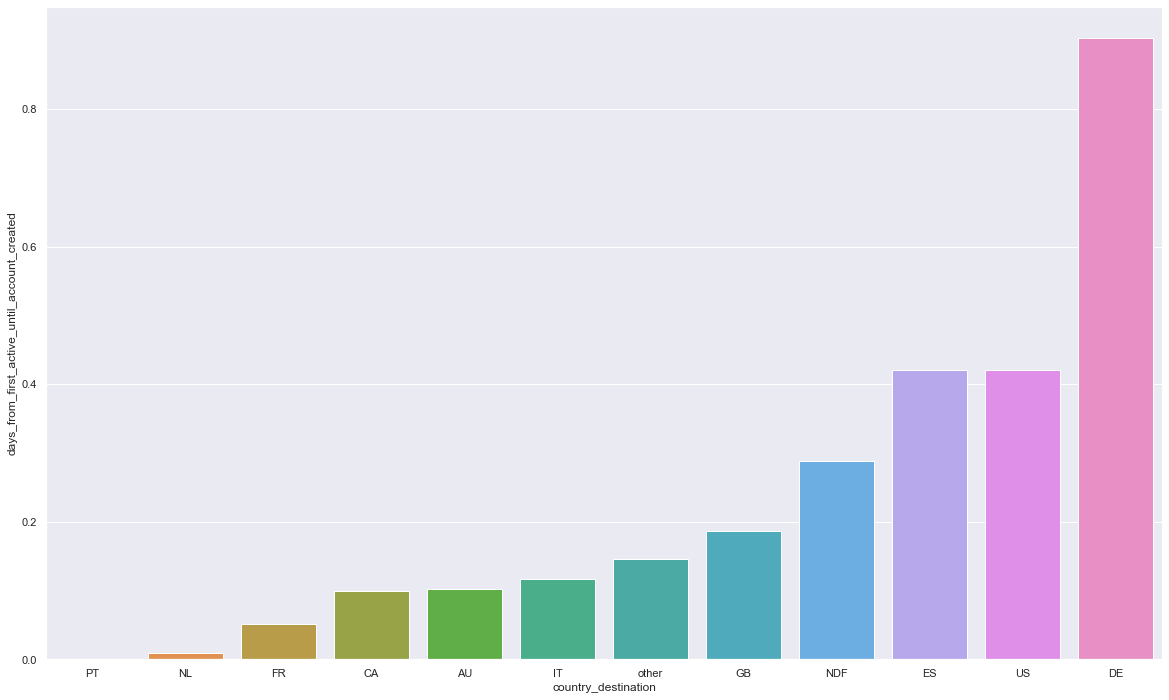

In [45]:
plt.figure( figsize=(20, 12))
aux01 = df51[['days_from_first_active_until_account_created', 'country_destination']].groupby( 'country_destination' ).mean().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values( 'days_from_first_active_until_account_created' ) )

**H03.** O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**False.** O Volume de reservas aumenta durante o verão entre os anos de 2010 até 2013.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

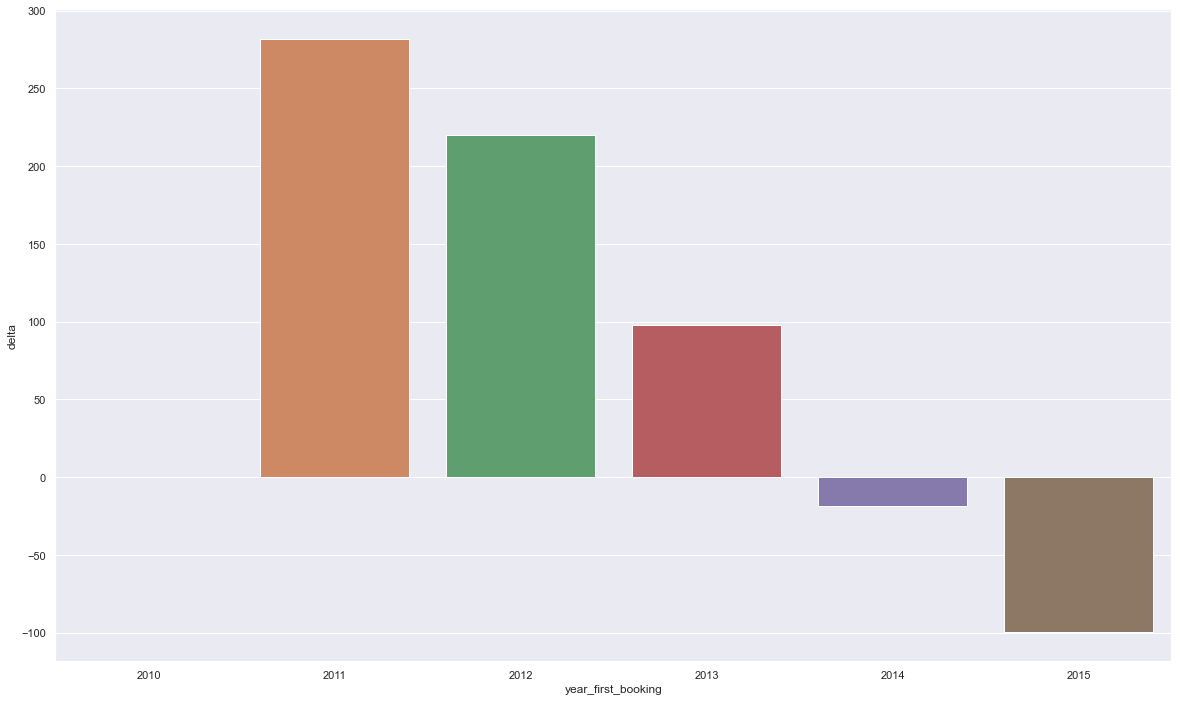

In [46]:
aux01 = df51[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby( ['year_first_booking', 'month_first_booking', 'country_destination'] ). \
                size().reset_index().rename( columns={0:'count'})

# select only summer
aux01 = aux01[( aux01['month_first_booking'].isin( [6, 7, 8, 9] ) ) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby( 'year_first_booking' ).sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna( 0 )

plt.figure( figsize=(20,12))
sns.barplot( x='year_first_booking', y='delta', data=aux02)

 **H04**. Usuários do sexo feminino fazem 10% mais reservas para países fora dos USA.

**H05.** O canal de Marketing Google representa 40% das reservas para países fora dos USA.

**H06.** O destino dos USA representam mais de 20% em todos os canais.

**H07.** A idade média das pessoas é de 35 anos em todos os destinos.

**H08.** A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90%

**H09.** O número de reservas do Airbnb é crescente ou decrescente ao longo dos anos?

**H10.** O número de reservas do Airbnb é crescente ao longo dos anos.

## 5.2 Variables Impact (Balanced Dataset)

In [47]:
profile = ProfileReport( df51, title='Airbnb Booking' )
#profile.to_notebook_iframe()
profile.to_file( output_file='airbnb_booking_statistics_after_cleaning.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 5.2.1 Univariate Analysis 

In [48]:
# ===================== High Correlation  ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# Remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# Remove: year_first_active

# month_first_active x month_account_created
# Remove: month_first_active

# day_first_active x day_account_created
# Remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# Remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# Remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# Remove: month_first_booking

# month_account_created x week_of_year_account_created
# Remove: month_account_created

# year_first_booking x year_account_created
# Remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# Remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# Remove: affiliate_provider

# first_device_type x first_browser
# Remove: first_browser

#first_device_type x sigup_app
#Remove: first_device_type

## 5.2.2 Bivariate Analysis 

In [49]:
df46.columns

Index(['signup_flow', 'days_from_first_active_until_booking',
       'days_from_first_active_until_account_created',
       'days_from_account_created_until_first_booking', 'year_first_active',
       'month_first_active', 'day_first_active', 'day_of_week_first_active',
       'week_of_year_first_active', 'year_first_booking',
       'month_first_booking', 'day_first_booking', 'day_of_week_first_booking',
       'week_of_year_first_booking', 'year_account_created',
       'month_account_created', 'day_account_created',
       'day_of_week_account_created', 'week_of_year_account_created', 'gender',
       'age', 'signup_method', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination'],
      dtype='object')

## 5.2.3 Multivariate Analysis 

In [50]:
cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
        'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language'] # high correlation

In [51]:
df46.columns

Index(['signup_flow', 'days_from_first_active_until_booking',
       'days_from_first_active_until_account_created',
       'days_from_account_created_until_first_booking', 'year_first_active',
       'month_first_active', 'day_first_active', 'day_of_week_first_active',
       'week_of_year_first_active', 'year_first_booking',
       'month_first_booking', 'day_first_booking', 'day_of_week_first_booking',
       'week_of_year_first_booking', 'year_account_created',
       'month_account_created', 'day_account_created',
       'day_of_week_account_created', 'week_of_year_account_created', 'gender',
       'age', 'signup_method', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination'],
      dtype='object')

#  6.0. Data Preparation

In [52]:
df6 = df46.drop( cols, axis=1 )
df6.dtypes

signup_flow                                       int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
day_first_booking                                 int64
day_of_week_first_booking                         int64
year_account_created                              int64
day_account_created                               int64
day_of_week_account_created                       int64
week_of_year_account_created                      int64
gender                                           object
age                                              object
signup_method                                    object
affiliate_channel                                object
first_affiliate_tracked                          object
signup_app                                       object
country_destination                              object
dtype: object

In [53]:
#df6.to_csv("df6.csv")87,40

In [54]:
df6 =  pd.read_csv('df6.csv', low_memory=True)
df6.shape

(546589, 17)

## 6.1. Rescaling

In [55]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [56]:
 # age - Standardization
df6['age'] = ss.fit_transform( df6[['age']].values )

# signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform( df6[['signup_flow']].values )

# days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = rs.fit_transform( df6[['days_from_first_active_until_account_created']].values )

# days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform( df6[['days_from_account_created_until_first_booking']].values )

# year_account_created - MinMax Scaler
df6['year_account_created'] = mms.fit_transform( df6[['year_account_created']].values )

## 6.1. Encoding

In [57]:
te = TargetEncoder()

In [58]:
# gender - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['gender'], columns=['gender'] )

# signup_method - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_method'], columns=['signup_method'] )

# signup_app - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_app'], columns=['signup_app'] )

# affiliate_channel - Target Encoder
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform( df6[['affiliate_channel']].values, df6['country_destination'].map( c ) )

# first_affiliate_tracked - Target Encoder
df6['first_affiliate_tracked'] = te.fit_transform( df6[['first_affiliate_tracked']].values, df6['country_destination'].map( c ) )

## 6.3. Transformation

In [59]:
# week_of_year_account_created
df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# day_account_created
df6['day_account_created_sin'] = df6['day_account_created'].apply( lambda x: np.sin( x * (2*np.pi/31 ) ) )
df6['day_account_created_cos'] = df6['day_account_created'].apply( lambda x: np.cos( x * (2*np.pi/31 ) ) )

# day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# 7.0 Feature Selection

In [60]:
df7 = df6.copy()

In [61]:
X = df6.drop('country_destination', axis=1)
y = df6['country_destination'].copy()

In [62]:
# Split dataset into training and test
x_train, x_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# 8.0 Machine Learning - Neural Network - MLP

## 8.1. Baseline Model 

In [65]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
# adding the weights according to column distribution "country_destination"
country_destination_weights= df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
# random model

yhat_random = random.choices(population=country_destination_list,
                             weights=country_destination_weights,              
                             k=k_num)

## 8.1.1 Baseline Model Performance

Accuracy: 0.09170493422858084
Balanced Accuracy: 0.08309942994678837
Kappa Score: 0.08309942994678837
              precision    recall  f1-score   support

          AU       0.06      0.00      0.01      7362
          CA       0.07      0.01      0.01      8609
          DE       0.08      0.01      0.01      7439
          ES       0.09      0.01      0.02     10084
          FR       0.07      0.03      0.04      8854
          GB       0.10      0.01      0.03     10560
          IT       0.07      0.02      0.03      7972
         NDF       0.10      0.45      0.16     10901
          NL       0.08      0.00      0.01      9547
          PT       0.11      0.00      0.00      9501
          US       0.09      0.39      0.14      9503
       other       0.09      0.06      0.07      8986

    accuracy                           0.09    109318
   macro avg       0.08      0.08      0.04    109318
weighted avg       0.08      0.09      0.05    109318



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

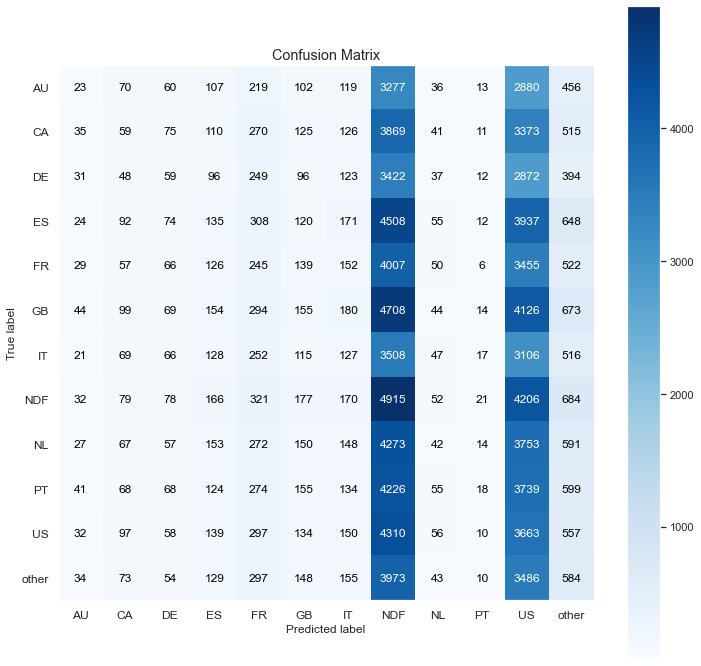

In [66]:
# Acurracy
acc_random = m.accuracy_score(y_test, yhat_random )
print("Accuracy: {}".format(acc_random))

# Balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print("Balanced Accuracy: {}".format(balanced_acc_random))

#Kappa Metrics
Kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print("Kappa Score: {}".format(balanced_acc_random))

#Classification report
print(m.classification_report(y_test, yhat_random))


# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12) )

# 8.2 Neural Network - MLP

In [67]:
# One Hot Encoder
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1) ).toarray()

In [68]:
y_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
x_train.shape

(437271, 32)

In [70]:
# model definition
model = ml.Sequential()
model.add(l.Dense( 64,input_dim=x_train.shape[1], activation='relu') )
model.add(l.Dense(12, activation="softmax") )

# model compile
model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )

model.fit( x_train, y_train_nn, epochs=100, verbose=0)

In [71]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

## 8.2.2 NN Performance

Accuracy: 0.6580800965989133
Balanced Accuracy: 0.6491910345933286
Kappa Score: 0.6260446317352694
              precision    recall  f1-score   support

          AU       0.95      0.67      0.79      7362
          CA       0.73      0.77      0.75      8609
          DE       0.68      0.72      0.70      7439
          ES       0.75      0.89      0.81     10084
          FR       0.85      0.28      0.42      8854
          GB       0.60      0.64      0.62     10560
          IT       0.52      0.59      0.56      7972
         NDF       0.90      1.00      0.94     10901
          NL       0.61      0.45      0.51      9547
          PT       0.43      1.00      0.60      9501
          US       0.70      0.80      0.75      9503
       other       0.00      0.00      0.00      8986

    accuracy                           0.66    109318
   macro avg       0.64      0.65      0.62    109318
weighted avg       0.64      0.66      0.62    109318



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

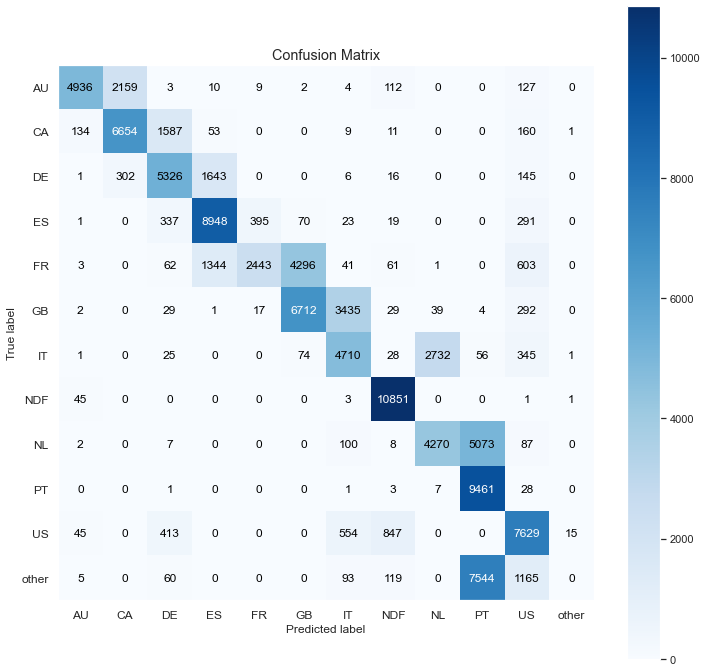

In [72]:
# Acurracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn )
print("Accuracy: {}".format(acc_nn))

# Balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print("Balanced Accuracy: {}".format(balanced_acc_nn))

#Kappa Metrics
Kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print("Kappa Score: {}".format(Kappa_nn))

#Classification report
print(m.classification_report(y_test_nn, yhat_nn))


# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12) )
#

## 8.2.3 NN Performance - Cross Validation

In [73]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_nn_list =[]
Kappa_nn_list = []
i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print("fold number: {}/{}".format(i, num_folds))
          
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding --> categorical to numeral
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # model defition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation="relu"))
    model.add(l.Dense(12, activation="softmax"))

    # compile model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn) # numeral to categorical


    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    Yhat_nn = yhat_nn.reshape(-1, 1)[0]

    # metrics

    # Balanced accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_nn_list.append(balanced_acc_nn)
    #print("Balanced Accuracy: {}".format(balanced_acc_nn))

    #Kappa Metrics
    Kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    Kappa_nn_list.append(Kappa_nn)
    #print("Kappa Score: {}".format(Kappa_nn))

    i += 1

fold number: 1/5
fold number: 2/5
fold number: 3/5
fold number: 4/5
fold number: 5/5


In [76]:
print("avg Balanced Accuracy:  {} +/- {}".format(round(np.mean(balanced_acc_nn_list), 4),
                                                np.round(np.std(balanced_acc_nn_list), 4)))


avg Balanced Accuracy:  0.4081 +/- 0.0608


In [77]:
print("avg Kappa score: {} +/- {}".format(np.round(np.mean(Kappa_nn_list), 4),
                                          np.round(np.std(Kappa_nn_list), 4)))

avg Kappa score: 0.3809 +/- 0.0686
